## Setup

In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler,LabelEncoder

import geopy.distance
from geopy.geocoders import Nominatim


2022-10-03 09:32:20.731889: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-03 09:32:20.736676: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/anaconda3-2021-05/lib:/cm/shared/apps/pbspro-ce/19.1.3/lib/
2022-10-03 09:32:20.736693: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf.__version__

'2.9.1'

## Data Processing

### Health Data

In [3]:
ae_data=pd.read_parquet('~/run/AXA_AE_app/AE_AXA_Lung_incidence.parquet')
ae_data=ae_data[['s0']].reset_index()
ae_dataB=pd.read_parquet('~/run/AXA_AE_app/AE_AXA_NonLung_incidence.parquet')
ae_dataB=ae_dataB[['s0']].reset_index()

In [4]:
def proc_ae(ae_data):
    # pd.unique(ae_data['s1'])
    # replace({'SOUTHERN PART OF ':''},regex=True)
    ae_data['s1'].replace({'RH':'Ruttonjee Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'PYN':'Pamela Youde Nethersole Eastern Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'QEH':'Queen Elizabeth Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'CMC':'Caritas Medical Centre'},regex=True,inplace=True)
    ae_data['s1'].replace({'KWH':'Kwong Wah Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'TMH':'Tuen Mun Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'PWH':'Prince of Wales Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'NDH':'North District Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'YCH':'Yan Chai Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'UCH':'United Christian Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'QMH':'Queen Mary Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'PWH':'Princess Margaret Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'POH':'Pok Oi Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'TKO':'Tseung Kwan O Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'AHN':'Alice Ho Miu Ling Nethersole Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'SJH':'St. John Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'NLT':'North Lantau Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'TSH':'Tang Shiu Kin Hospital'},regex=True,inplace=True)
    ae_data['s1'].replace({'PMH':'Princess Margaret Hospital'},regex=True,inplace=True)
    ae_data.columns=[['cd9_loc','date','diag1']]
    return ae_data

In [5]:
ae_data=proc_ae(ae_data)
ae_data.to_csv('~/run/AXA_AE_app/Lung_incidence.txt',sep='\t')
ae_dataB=proc_ae(ae_dataB)
ae_dataB.to_csv('~/run/AXA_AE_app/nonLung_incidence.txt',sep='\t')

In [42]:
import geopy.distance
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="example app")
df_loc=pd.DataFrame(columns=['lat','long','name'])
for ii,i in enumerate(np.unique(ae_data['cd9_loc'].values)):
    a,b,c=geolocator.geocode(str(i)+", Hong Kong").point
    df_loc[ii]=[a,b,i]
    

df_loc=df_loc.transpose()
df_loc.columns=['lat','long','name']
df_loc=df_loc[3:]
hosp_loc=df_loc

### Poll Data

In [29]:
# !wget -P run/AXA_AE_app/poll_data/ https://cd.epic.epd.gov.hk/EPICDI/air/yearly/data/{1990..2021}_EN.xlsx

# dir_list=os.listdir('poll_data')
# np.sort(dir_list)[-12:]

# df=pd.DataFrame(columns=['DATE','STATION','HOUR','CO','FSP','NO2','NOX','O3','RSP','SO2'])
# dir_list=os.listdir('poll_data/')
# for f in np.sort(dir_list)[-12:]:
#     data = pd.read_excel('poll_data/'+f,skiprows=11)
#     df = df.append(data,ignore_index=True)
# df.columns=['date','loc','hour','co','fsp','no2','nox','o3','rsp','so2']
# df.to_csv('epd_poll_data.txt',sep='\t')
# df.to_pickle('epd_poll_data.pkl')
import pyarrow as pa
import pyarrow.parquet as pq

poll_data=pd.read_pickle('~/run/AXA_AE_app/epd_poll_data.pkl')
poll_data['date']=pd.to_datetime(poll_data['date'])
pd.to_datetime(poll_data['date']).dt.isocalendar().day
poll_data['co']=pd.to_numeric(poll_data['co'], errors='coerce')#,'FSP','NO2','NOX','O3','RSP','SO2']])
poll_data['fsp']=pd.to_numeric(poll_data['fsp'], errors='coerce')
poll_data['no2']=pd.to_numeric(poll_data['no2'], errors='coerce')
poll_data['nox']=pd.to_numeric(poll_data['nox'], errors='coerce')
poll_data['o3']=pd.to_numeric(poll_data['o3'], errors='coerce')
poll_data['rsp']=pd.to_numeric(poll_data['rsp'], errors='coerce')
poll_data['so2']=pd.to_numeric(poll_data['so2'], errors='coerce')

CC=poll_data.groupby(by=['loc','date']).mean().reset_index()


In [298]:

geolocator = Nominatim(user_agent="example app")
poll_loc=pd.DataFrame(columns=['lat','long','name'])

for ii,i in enumerate(np.unique(CC['loc'].values)):
    a,b,c=geolocator.geocode(str(i)+", Hong Kong").point
    poll_loc[ii]=[a,b,i]

    
poll_loc=poll_loc.transpose()

poll_loc.columns=['lat','long','name']
poll_loc=poll_loc[3:]

hosp_loc=hosp_loc.append(poll_loc)
hosp_loc=hosp_loc[hosp_loc['name']!='SOUTHERN']


/tmp/ipykernel_1596/103699425.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hosp_loc=hosp_loc.append(poll_loc)


In [299]:
def get_distance(col):
    end = data_loc.loc[col.name, 'latlon']
    return data_loc['latlon'].apply(geopy.distance.distance,
                              args=(end,),
                              ellipsoid='WGS-84'
                             )
distances = square.apply(get_distance, axis=1).T

In [300]:
data_loc=hosp_loc
data_loc['latlon'] = list(zip(data_loc['lat'], data_loc['long']))

square = pd.DataFrame(
    np.zeros((data_loc.shape[0], data_loc.shape[0])),
    index=data_loc.index, columns=data_loc.index
)
data_loc.reset_index(inplace=True)


def get_distance(col):
    end = data_loc[['name','latlon']]#data_loc.loc[col.name, 'latlon']
    return data_loc['latlon'].apply(geopy.distance.distance,
                              args=(end,),
                              ellipsoid='WGS-84'
                             )
distances = square.apply(get_distance, axis=1).T


data_loc['src']=data_loc['name']
data_loc['dst']=data_loc['name']

# np.sum((distances<5)*1)
# D_D=pd.DataFrame((distances<5)*1)
# D_D.index=data_loc['src']
# D_D.columns=data_loc['dst']

# E_E=pd.DataFrame(D_D.stack())#.reset_index(inplace=True)
# # E_E.rename=['source','target']#.reset_index(inplace=True)#.rename(columns={'level_0':'Source','level_1':'Target', 0:'Weight'})
# E_E.reset_index(inplace=True)#
# # distance_mat=E_E[E_E[0]>0]

distanceA=distances
distanceA.index=data_loc['src']
distanceA.columns=data_loc['dst']
# distanceA=pd.DataFrame(distance.stack())
# distanceA.reset_index(inplace=True)

#prepare for TF

distances=distances.astype(str) # df.astype(np.float64)#lues.as_int#('int')#.to_numpy()
distances=distances.replace('km', '', regex=True)
distances=distances.astype(np.float64)
distances.shape

distances=np.round(distances,5)


ValueError: cannot insert level_0, already exists

In [ ]:
distanceA=pd.DataFrame(distance.stack())
distanceA.reset_index(inplace=True)
distanceA

In [288]:
import networkx as nx
plt.figure(figsize=(5, 5))
# # colors = papers["subject"].tolist()
# cc=JJJ.reset_index()[['index','kmeans{k}']]
# cc.rename(columns={'index':'source','kmeans{k}':'target'},inplace=True)
# cc['source']=cc['source'].astype('int')
# cc['target']=cc['target'].astype('int')

distanceA.rename(columns={'src':'source','trg':'target'},inplace=True)

cora_graph = nx.from_pandas_edgelist(distanceA)
# subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15)


KeyError: 'source'

<Figure size 360x360 with 0 Axes>

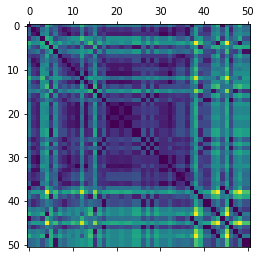

In [109]:
# distances.drop('SOUTHERN',inplace=True)
plt.matshow(distances)


In [ ]:

from sklearn.cluster import DBSCAN#, DBSCAN
clustering = DBSCAN(eps=.00005,min_samples=2).fit(distances.values)
data_loc['cluster']=clustering.labels_
print('all hospitals have pollution data : '+ str(len(clustering.labels_))==18)
# clustering.labels_


False


In [49]:
dd=[]
distances.reset_index(inplace=True) ## only run once
for j,i in enumerate(distances['src'][:18]):
    # print(i,j)
    cc=distances[distances[i]==np.min(distances.iloc[19:,:19],axis=0)[j+1]]['src']
    dd.append(i+'_'+(cc.iloc[0]))

In [50]:
dd=pd.DataFrame(dd)
key = pd.DataFrame(dd[0].str.split('_').to_list(), columns=['cd9_loc','poll'])
CC=CC.merge(key,left_on='loc',right_on='poll')
# CC.rename(columns={'DATE':'date'},inplace=True)

In [69]:
ae_data=pd.read_csv('~/run/AXA_AE_app/Lung_incidence.txt',sep='\t')
ae_data['date']=pd.to_datetime(ae_data['date'])
ddd=pd.merge(ae_data,CC,on=['date','cd9_loc'])
table = pa.Table.from_pandas(ddd.astype(str))
pq.write_table(table, '~/run/AXA_AE_app/ae_epd_poll_data.parquet')

In [54]:
ae_dataB=pd.read_csv('~/run/AXA_AE_app/nonLung_incidence.txt',sep='\t')
ae_dataB['date']=pd.to_datetime(ae_dataB['date'])
eee=pd.merge(ae_dataB,CC,on=['date','cd9_loc'])
table = pa.Table.from_pandas(eee.astype(str))
pq.write_table(table, '~/run/AXA_AE_app/ae_non-epd_poll_data.parquet')

### arxiv

In [ ]:
%%script false --no-raise-error
# !wget https://github.com/dcolinmorgan/AXA_AE_app/blob/main/AE_AXA_poll-ae.parquet?raw=true
data=pd.read_parquet('/content/AE_AXA_poll-ae.parquet?raw=true')

# !wget https://github.com/dcolinmorgan/AXA_AE_app/blob/main/edmond_datasets.pickle?raw=true
# data=pd.read_pickle('edmond_datasets.pickle?raw=true')

In [ ]:
%%script false --no-raise-error
# data=pd.read_parquet('/content/AE_AXA_poll-ae.parquet?raw=true')
L_data=pd.read_parquet('~/run/AXA_AE_app/AE_AXALung_incidence.parquet')
# NL_data=pd.read_parquet('~/run/AXA_AE_app/AE_AXA_NonLung_incidence.parquet')

# load dataset
# dataset = read_csv('pollution.csv', header=0, index_col=0)
# data=pd.read_parquet('~/run/AXA_AE_app/AE_AXA_poll-ae.parquet')
data['loca']=data.groupby('cd9_loc').ngroup()
data2=pd.DataFrame()
for loc in np.unique(data.loca):
    # data=pd.read_parquet('~/run/AXA_AE_app/AE_AXA_poll-ae.parquet')
    
    datum=data[data['loca']==loc]
    datum=datum.groupby(['loca','date','cd9_loc']).agg('mean')[['pm25','pm10','o3','no2','so2','co','age','sex','diag1']]
    datum.reset_index(inplace=True)
    idx = pd.date_range(min(data['date']), max(data['date']))
    datum.index = pd.DatetimeIndex(datum['date'])#.fillna()

    # s.index = pd.DatetimeIndex(s.index)

    datum = datum.reindex(idx, fill_value=np.nan)
    datum['date']=datum.index
    datum['loca']=loc #fillna(method='ffill',inplace=True)
    if datum['pm25'].isna().sum() < 2922/1.5: 
        data2=pd.concat([data2,datum],axis=0)
# data2['date']=data2.index
data=data2
# data['loca'].fillna(method='ffill',inplace=True)
# data.reset_index(inplace=True)
# data['loca']=data.groupby('cd9_loc').ngroup()
data['date']=(data['date']-data['date'][0]).dt.days

data=data[['loca','cd9_loc','date','pm25','pm10','o3','no2','so2','co','age','sex','diag1']]
data=data.groupby(['loca','cd9_loc','date']).agg('mean')[['pm25','pm10','o3','no2','so2','co','age','sex','diag1']]

data.age=np.round(data.age)
data.sex=np.round(data.sex)
data.sort_values(by=['loca','date'],inplace=True)
first_column = data.pop('diag1')
data.insert(0, 'diag1', first_column)
data.reset_index(inplace=True)
data.fillna(method='bfill',inplace=True)
data.fillna(method='ffill',inplace=True)

# scaler = MinMaxScaler(feature_range=(0, 1))
dataset = data.drop(['cd9_loc'],axis=1).values #scaler.fit_transform(data.drop(['cd9_loc'],axis=1))
cc=data['cd9_loc']
# dataset = data.drop(['cd9_loc'],axis=1).values
data=pd.DataFrame(dataset)
data.columns=['loca','date','diag1','pm25','pm10','o3','no2','so2','co','age','sex']
data['cd9_loc']=cc

# specify columns to plot
groups = [0, 1,2, 3, 4, 5, 6, 7, 8,9,10]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(dataset[:, group])
	plt.title(data.drop('cd9_loc',axis=1).columns[group], y=0.5, loc='right')
	i += 1
plt.show()

## Graph data

In [70]:
import geopy.distance
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="example app")
df_loc=pd.DataFrame(columns=['lat','long','name'])
for ii,i in enumerate(pd.unique(ddd['cd9_loc'])):
    a,b,c=geolocator.geocode(str(i)+", Hong Kong").point
    df_loc[ii]=[a,b,i]
df_loc=df_loc.transpose()
df_loc.columns=['lat','long','name']
df_loc=df_loc[3:]

In [71]:
data_loc=df_loc
data_loc['latlon'] = list(zip(data_loc['lat'], data_loc['long']))

square = pd.DataFrame(
    np.zeros((data_loc.shape[0], data_loc.shape[0])),
    index=data_loc.index, columns=data_loc.index
)

def get_distance(col):
    end = data_loc.loc[col.name, 'latlon']
    return data_loc['latlon'].apply(geopy.distance.distance,
                              args=(end,),
                              ellipsoid='WGS-84'
                             )
distances = square.apply(get_distance, axis=1).T

data_loc['src']=data_loc['name']
data_loc['dst']=data_loc['name']

# np.sum((distances<5)*1)
D_D=pd.DataFrame((distances<5)*1)
D_D.index=data_loc['src']
D_D.columns=data_loc['dst']

E_E=pd.DataFrame(D_D.stack())#.reset_index(inplace=True)
# E_E.rename=['source','target']#.reset_index(inplace=True)#.rename(columns={'level_0':'Source','level_1':'Target', 0:'Weight'})
E_E.reset_index(inplace=True)#
distance_mat=E_E[E_E[0]>0]

distance=distances
distance.index=data_loc['src']
distance.columns=data_loc['dst']
distance=pd.DataFrame(distance.stack())
distance.reset_index(inplace=True)

#prepare for TF

distances=distances.astype(str) # df.astype(np.float64)#lues.as_int#('int')#.to_numpy()
distances=distances.replace('km', '', regex=True)
distances=distances.astype(np.float64)
distances.shape


(18, 18)

In [72]:
def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
 
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

In [73]:

class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = .99998
adjacency_matrix = compute_adjacency_matrix(distances, sigma2, epsilon)

# distances=np.random.permutation(distances)

# adjacency_matrix =np.where(distances > 15, 0, 1)

node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 18, number of edges: 146


In [74]:
adjacency_matrix.shape

(18, 18)

<Figure size 576x576 with 0 Axes>

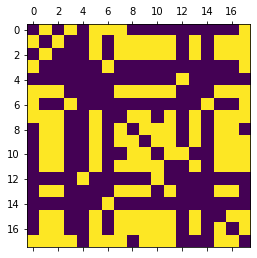

In [75]:
plt.figure(figsize=(8, 8))
# adjacency_matrix=adjacency_matrix.iloc[:17,:17]
plt.matshow((adjacency_matrix))

## LSTM data

In [ ]:
# measures_array=data.pivot_table(values=['pm25','pm10','o3','no2','so2','co'], index='date', columns=['loca'], aggfunc='mean').fillna(method='bfill')
# measures_array=measures_array.dropna().values
# measures_array=measures_array.reshape([measures_array.shape[0],14,6])
# measures_array.shape

In [ ]:
# measures_array=ddd.pivot_table(values=['diag1','FSP','RSP','NOX','O3','NO2','CO','SO2'], index='date', columns=['cd9_loc'], aggfunc='mean').fillna(method='bfill')

# measures_array=measures_array.fillna(method='ffill').dropna(how='all')
# len(np.unique(measures_array['cd9_loc']))

In [76]:
# measures_array=data.pivot_table(values=['pm25','pm10','o3','no2','co','so2','age','sex'], index='date', columns=['loca'], aggfunc='mean').fillna(method='bfill')
# measures_array=ddd.pivot_table(values=['diag1','FSP','RSP','SO2','O3','NO2','CO','NOX'], index='date', columns=['cd9_loc'], aggfunc='mean').fillna(method='bfill')
measures_array=ddd.pivot_table(values=['diag1','fsp','rsp','so2','o3','no2'], index='date', columns=['cd9_loc'], aggfunc='mean')#.fillna(method='ffill')
## COand NOX missing locations
measures_array=measures_array.fillna(method='ffill').dropna().values ## ffill more NaN
measures_array=measures_array.reshape([measures_array.shape[0],6,18])
measures_array=np.transpose(measures_array, [0, 2, 1])

measures_array.shape
# cc=measures_array[:,:,2]
# measures_array[:,:,0]=measures_array[:,:,2] ## move diag1 to 0 index
# measures_array[:,:,2]=cc
# measures_array.T.dropna().reset_index()['cd9_loc'][1:20] ##age will be predicted here

(540, 18, 6)

In [77]:
# plt.plot(measures_array[:,:,0]) ## check diag1 is 0 index 3rd dim

In [78]:
# measures_array=data.pivot_table(values=['pm10'], index='date', columns=['loca'], aggfunc='mean').fillna(method='bfill').values


In [79]:
np.isfinite(measures_array).all()


True

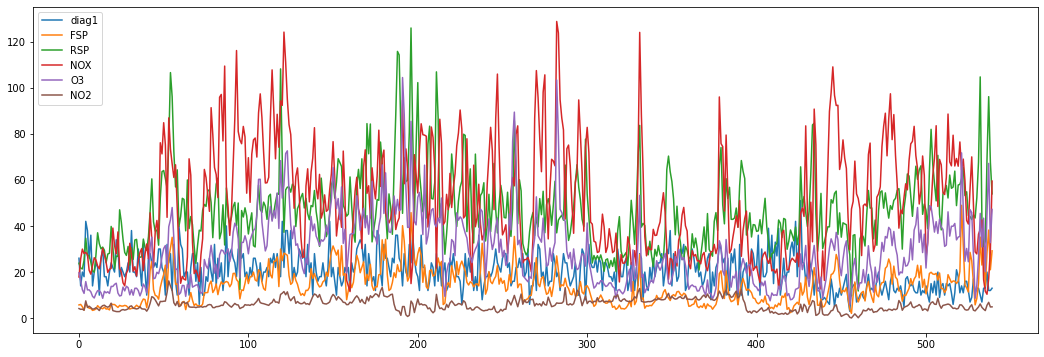

In [80]:
plt.figure(figsize=(18, 6))
plt.plot(measures_array[:,1])
plt.legend(['diag1','fsp','rsp','nox','o3','no2','co','so2'])
# plt.legend(["route_0", "route_25"])

In [81]:
train_size, val_size = 0.5, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array )#- mean) / std
    val_array = (data_array[num_train : (num_train + num_val)])# - mean) / std
    test_array = (data_array[(num_train + num_val) :])# - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(measures_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (270, 18, 6)
validation set size: (108, 18, 6)
test set size: (162, 18, 6)


In [82]:
np.isfinite(train_array).all()
# np.isfinite(b_0).all()

True

In [83]:

class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)


In [84]:

class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")#,return_sequences=True)
        self.dense = layers.Dense(output_seq_len)
        # self.dense = layers.Dense(1)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)


In [85]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 21
forecast_horizon = 7
multi_horizon = True


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    if data_array.shape[2] ==1:
      inputs = timeseries_dataset_from_array(
          np.expand_dims(data_array[:-forecast_horizon], axis=-1),
          None,
          sequence_length=input_sequence_length,
          shuffle=False,
          batch_size=batch_size,
      )

    else:
      inputs = timeseries_dataset_from_array(
          data_array[:-forecast_horizon,:,1:],
          None,
          sequence_length=input_sequence_length,
          shuffle=False,
          batch_size=batch_size,
      )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:,:,0],
        # data_array[:,:,0],
        # np.expand_dims(data_array[target_offset:,:,0], axis=-1),
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

train_dataset

2022-10-03 09:59:56.050344: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-03 09:59:56.050391: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hpc-hn001): /proc/driver/nvidia/version does not exist
2022-10-03 09:59:56.051185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<CacheDataset element_spec=(TensorSpec(shape=(None, None, 18, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 18), dtype=tf.float64, name=None))>

## Model training

In [86]:
val_dataset

<CacheDataset element_spec=(TensorSpec(shape=(None, None, 18, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 18), dtype=tf.float64, name=None))>

In [87]:
keras.backend.clear_session()

in_feat = val_dataset.element_spec[0].shape[3]
batch_size = 64
epochs = 20
# input_sequence_length = 
# forecast_horizon = 
multi_horizon = False
out_feat = 14
lstm_units = 256
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanAbsoluteError(),
)

In [88]:

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)],
)

Epoch 1/20
4/4 [==============================] - 2s 212ms/step - loss: 31.3154 - val_loss: 18.9378
Epoch 2/20
4/4 [==============================] - 0s 119ms/step - loss: 23.5349 - val_loss: 15.9254
Epoch 3/20
4/4 [==============================] - 0s 126ms/step - loss: 18.9583 - val_loss: 14.5146
Epoch 4/20
4/4 [==============================] - 0s 128ms/step - loss: 17.0715 - val_loss: 14.3364
Epoch 5/20
4/4 [==============================] - 0s 120ms/step - loss: 16.1376 - val_loss: 12.0363
Epoch 6/20
4/4 [==============================] - 0s 120ms/step - loss: 14.6882 - val_loss: 12.2032
Epoch 7/20
4/4 [==============================] - 0s 119ms/step - loss: 14.7606 - val_loss: 11.6116
Epoch 8/20
4/4 [==============================] - 0s 121ms/step - loss: 14.2974 - val_loss: 11.9808
Epoch 9/20
4/4 [==============================] - 1s 141ms/step - loss: 14.4257 - val_loss: 11.8363
Epoch 10/20
4/4 [==============================] - 1s 137ms/step - loss: 15.8517 - val_loss: 11.3383

## Making forecasts on test set

Now we can use the trained model to make forecasts for the test set. Below, we
compute the MAE of the model and compare it to the MAE of naive forecasts.
The naive forecasts are the last value of the measure for each node.

In [378]:
# from sklearn.metrics import mean_absolute_error,r2_score,accuracy_score,roc_curve,precision_recall_curve,auc,matthews_corrcoef
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LarsCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
# from sklearn.linear_model import RandomForestClassifier, AdaBoostClassifier
# from sklearn.gausslinear_modelian_process import GaussianProcessClassifier
# from sklearn.linear_model import MLPClassifier

(4860, 6)

5/5 [==============================] - 0s 28ms/step


2022-10-03 16:41:33.243702: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


model MSE: 3.2472094256886974,naive MSE: 15.199857993520714, ElNet MSE:14.849210315541084


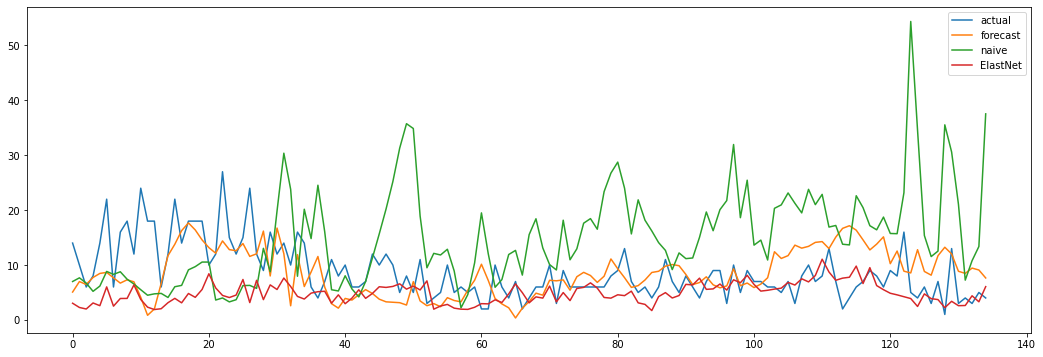

In [393]:
## with randomized graph
from sklearn.linear_model import ElasticNet
train_array2=np.transpose(train_array, [2,0,1])
cc=train_array2.reshape(train_array.shape[0]*train_array.shape[1],train_array.shape[2])
cc.shape

x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)

# MLP=LarsCV().fit(cc[:-135,1:],cc[:-135,0])
# predB=MLP.predict(cc[-135:,1:])

EN=ElasticNet().fit(cc[:-135,1:],cc[:-135,0])
predA=EN.predict(cc[-135:,1:])

plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.plot(x_test[:, -1, 0,0])
plt.plot(predA)
# plt.plot(predB)
plt.legend(["actual",'forecast', "naive","ElastNet"])

naive_mse, model_mse, EL_mse = (
    # np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    # np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),

    np.square(np.nanmean(x_test[:, -1, :,0] - y[:, 0, :])),
    np.square(np.nanmean(y_pred[:, 0, :] - y[:, 0, :])),
    np.square(np.nanmean(predA - y[:, 0,0])),
    # np.square(np.nanmean(predB - y[:, 0,0])),
)
print(f"model MSE: {model_mse},naive MSE: {naive_mse}, ElNet MSE:{EL_mse}")

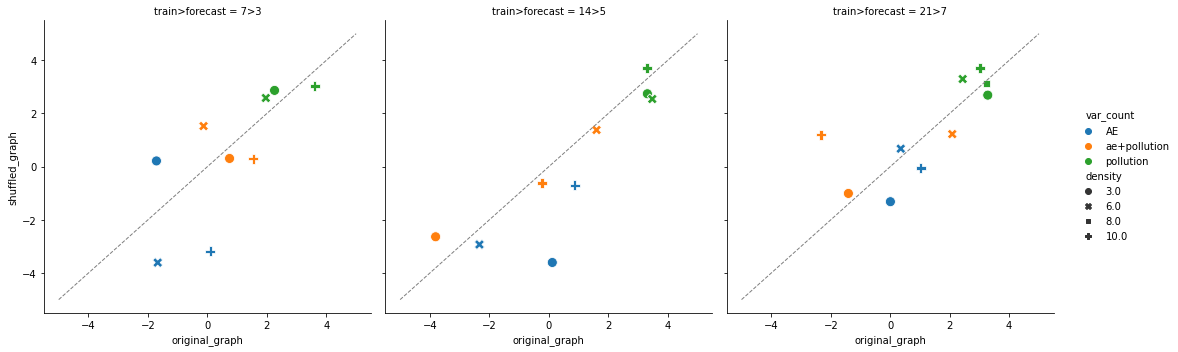

In [394]:
jeff=pd.read_csv('~/run/AXA_AE_app/GNNtest/GNN_mse.txt',sep='\t',index_col=0)
l=[]
import ast,seaborn as sns
for i in np.arange(len(jeff['var'])):
    l.append(len(ast.literal_eval(jeff['var'][i])))

jeff['var_count']=l
jeff['var_count']=jeff['var_count']-1
jeff.rename(columns={'ftime':'train>forecast'},inplace=True)
jeff['train>forecast'].replace({7:'7>3',14:'14>5',21:'21>7'},inplace=True)
jeff['shuf'].replace({0:'original_graph',1:'shuffled_graph'},inplace=True)
jeff['var_count'].replace({1:'AE',5:'pollution',6:'ae+pollution'},inplace=True)
jeff['density']=np.round(jeff['edges']/jeff['graph_shape'],0)
jeff['density'].replace({9:10},inplace=True)

cc=jeff[['shuf','train>forecast','density','mse','naive_mse','var_count']]
R=cc.melt(id_vars=['var_count','shuf','train>forecast','density'],ignore_index=False).reset_index()
table = pd.pivot_table(R, values='value', index=['shuf'],columns=['var_count','train>forecast','density']).T#, aggfunc=np.sum)
table.reset_index(inplace=True)
# table.rename(columns={'kmeans{k}':'kmeans'},inplace=True)
# table.rename(columns={'index':'method'},inplace=True)
# table.rename(columns={'test':'data'},inplace=True)
# table.rename(columns={'variable':'metric'},inplace=True)

# table.replace({'group': 0}, 'urban',inplace=True)
# table.replace({'group': 1}, 'rural',inplace=True)
table[['original_graph','shuffled_graph']]=np.log(table[['original_graph','shuffled_graph']])
g=sns.relplot(data=table, x='original_graph', y='shuffled_graph', col='train>forecast',
              col_order=('7>3','14>5','21>7'),hue='var_count',style='density',kind="scatter",s=100)#,xlim = (.3,.8), ylim = (.3,.8))
# g.set(ylim=(0.4, .7))
# g.set(xlim=(0.4, .7))

def const_line(*args, **kwargs):
    x = (-5,5)#np.arange(0, 50, .5)
    y = (-5,5)#0.2*x
    plt.plot(y, x,ls='--', linewidth=1, color='grey')#, C='k')

g.map(const_line)

g.savefig('GNNtest/performance.png')
